In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'
%pylab inline

from __future__ import division
import rdflib
from rdflib.graph import Graph, ConjunctiveGraph
from rdflib import Graph, URIRef, BNode, Literal
from rdflib import RDF
from rdflib import Namespace
from rdflib.namespace import OWL, RDF, RDFS, FOAF, XSD
from SPARQLWrapper import SPARQLWrapper, JSON
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry.multipolygon import MultiPolygon
from shapely import wkt
from descartes import PolygonPatch
from shapely.geometry.polygon import LinearRing
import seaborn as sns
import pandas as pd
from matplotlib.collections import PatchCollection

from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

pathPresentation = 'C:\Users\massaro\Google Drive\Herus all new\Projects\La Mobiliere\Presentations'

Populating the interactive namespace from numpy and matplotlib


In [3]:
def reverse_colourmap(cmap, name = 'my_cmap_r'):
    """
    In: 
    cmap, name 
    Out:
    my_cmap_r

    Explanation:
    t[0] goes from 0 to 1
    row i:   x  y0  y1 -> t[0] t[1] t[2]
                   /
                  /
    row i+1: x  y0  y1 -> t[n] t[1] t[2]

    so the inverse should do the same:
    row i+1: x  y1  y0 -> 1-t[0] t[2] t[1]
                   /
                  /
    row i:   x  y1  y0 -> 1-t[n] t[2] t[1]
    """        
    reverse = []
    k = []   

    for key in cmap._segmentdata:    
        k.append(key)
        channel = cmap._segmentdata[key]
        data = []

        for t in channel:                    
            data.append((1-t[0],t[2],t[1]))            
        reverse.append(sorted(data))    

    LinearL = dict(zip(k,reverse))
    my_cmap_r = mpl.colors.LinearSegmentedColormap(name, LinearL) 
    return my_cmap_r

In [4]:
def plotIndicators(cmap, value, results1):
    cmap_r = reverse_colourmap(cmap)
    norm = matplotlib.colors.Normalize(min(value), max(value))
    color_producer = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap_r)
    count = -1
    bg_color = 'white'
    fg_color = 'black'

    fig = plt.figure(facecolor=bg_color, edgecolor=fg_color, figsize=(18,12))
    axes = plt.axes(axisbg=bg_color)
    axes.xaxis.set_tick_params(color=fg_color, labelcolor=fg_color)
    axes.yaxis.set_tick_params(color=fg_color, labelcolor=fg_color)
    for spine in axes.spines.values():
        spine.set_color(fg_color)
    axes.grid(False)
    for result in results1["results"]["bindings"]: 
        count += 1
        if len(mergeVal[mergeVal.index == count])  > 0:
            tmp = result["Coords"]['value']
            p = wkt.loads(tmp)
            cc = color_producer.to_rgba( value[count] )            
            ptchs   = []
            for polygon in p:
            #plot_coords(ax, polygon.exterior)
                patch = PolygonPatch(polygon, facecolor=cc,
                                 edgecolor= 'k', alpha=0.5, zorder=2)
                ptchs.append(patch)
                h = PatchCollection(ptchs,facecolor=cc, linewidths = 1)
                axes.add_patch(patch)
    axes.set_xlim(6, 10.5)
    axes.set_ylim(45.7,48)

    plt.axis('off')
    h.set(array = value, cmap=cmap_r)
    cbaxes = inset_axes(axes, width="50%", height="3%", loc=1) 
    cb = plt.colorbar(h, cax=cbaxes, orientation='horizontal', format='%.0e')
    cb.ax.yaxis.set_tick_params(color='white')

# Table of Contents
* [1. Define Ontologie and Vocabulary](#1.-Define-Ontologie-and-Vocabulary)
* [2. Get the Data](#2.-Get-the-Data)
    * [2.1 Sparql](#2.1-Sparql)
    * [2.2 Store the Data](#2.2-Store-the-Data)
* [3. Plot Cantons Population](#3.-Plot-Cantons-Population)
* [4. Plot District Population](#4.-Plot-District-Population)

# 1. Define Ontologie and Vocabulary

In [5]:
schema = rdflib.Namespace('http://schema.org/')
time   = rdflib.Namespace('http://www.w3.org/2006/time#')
dbo    = rdflib.Namespace('http://dbpedia.org/ontology/')
dbp    = rdflib.Namespace('http://dbpedia.org/property/')
res    = rdflib.Namespace('http://dbpedia.org/resource/')
rdf    = rdflib.Namespace('http://www.w3.org/1999/02/22-rdf-syntax-ns#')
rdfs   = rdflib.Namespace('http://www.w3.org/2000/01/rdf-schema#')

In [6]:
g = Graph()
FOCUS = Namespace("http://www.semanticweb.org/massaro/swissData/")
g.bind("focus", FOCUS)
# Create the node to add to the Graph
country = URIRef(FOCUS["country"])

# 2. Get the data

## 2.1 Sparql

In [7]:
sparql = SPARQLWrapper("https://sparql.geo.admin.ch/sparql")
query = """
PREFIX schema: <http://schema.org/>
PREFIX gn: <http://www.geonames.org/ontology#>
PREFIX geo: <http://www.opengis.net/ont/geosparql#>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX wikibase: <http://wikiba.se/ontology#>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX fn: <http://www.w3.org/2005/xpath-functions#>


select ?Population ?Coords ?municipalityName 
?Canton ?cantonName  ?populationCanton 
?District ?districtName ?populationDistrict
?WikidataURI ?GeoNamesURI ?PostalCode ?MunicipalityCode
where
{
    ?Municipality a gn:A.ADM3.
    ?Municipality schema:name ?municipalityName .
    ?Municipality gn:population ?Population .
    ?Municipality geo:hasGeometry ?Geometry .
    ?Geometry geo:asWKT ?Coords.
    
    ?Municipality gn:parentADM1 ?Canton.
    ?Canton schema:name ?cantonName .
    ?Canton gn:population ?populationCanton .
    
    ?Municipality gn:parentADM2 ?District.
    ?District schema:name ?districtName .
    ?District gn:population ?populationDistrict .   

    ?Municipality <https://ld.geo.admin.ch/def/bfsNumber> ?bfsNumber.
    ?Municipality <http://purl.org/dc/terms/issued> ?Date .
    FILTER (?Date = "2016-01-01"^^xsd:date)
    {
    SELECT DISTINCT (xsd:integer(?bfs) AS ?bfsNumber) ?WikidataURI ?GeoNamesURI ?PostalCode ?MunicipalityCode WHERE {
        SERVICE <https://query.wikidata.org/bigdata/namespace/wdq/sparql>
        {
            ?WikidataURI wdt:P771 ?bfs . #look for bfs number in WD
            ?WikidataURI wdt:P31 wd:Q70208 . #municipality of Switzerland
            ?WikidataURI wdt:P1566 ?GeoNamesId .
            ?WikidataURI wdt:P281 ?PostalCode .
            ?WikidataURI wdt:P771 ?MunicipalityCode .
        }
      BIND(IRI(CONCAT(STR("http://sws.geonames.org/"), ?GeoNamesId, "/")) AS ?GeoNamesURI)
    }
    }
    
}
ORDER BY DESC(?Population)
"""
sparql.setQuery(query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()

## 2.2 Store the Data

In [8]:
c = 0
pop = []
name = []
canton = []
district = []
for result in results["results"]["bindings"]:
    c = c + 1
    nameC = "municipality%d"%c
    idS = URIRef(FOCUS[nameC])
    g.add((idS, RDF.type, dbo.municipality))
    
    tmp = Literal(result["municipalityName"]['value'])
    g.add((idS, FOAF.name, tmp))
    
    tmp = Literal(result["Population"]['value'])
    g.add((idS, dbo.populationTotal, tmp))
    
    tmp = Literal(result["MunicipalityCode"]['value'])
    g.add((idS, dbo.municipalityCode, tmp))
    
    
    ### Add Cantons
    tmp = Literal(result["Canton"]['value'])
    if tmp not in canton:
        tmpN = len(canton)
        canton.append(tmp)
        nameZ = "canton%d"%(tmpN+1)
        idC = URIRef(FOCUS[nameZ])
        g.add((idC, RDF.type, dbo.canton))
        tmp = Literal(result["populationCanton"]['value'])
        g.add((idC, dbo.populationTotal, tmp))
        tmp = Literal(result["cantonName"]['value'])
        g.add((idC, FOAF.name, tmp))
    
    ### Add district
    tmp = Literal(result["District"]['value'])
    if tmp not in district:
        tmpN = len(district)
        district.append(tmp)
        nameZ = "district%d"%(tmpN+1)
        idC = URIRef(FOCUS[nameZ])
        g.add((idC, RDF.type, dbo.district))
        tmp = Literal(result["populationDistrict"]['value'])
        g.add((idC, dbo.populationTotal, tmp))
        tmp = Literal(result["districtName"]['value'])
        g.add((idC, FOAF.name, tmp))
    

    tmp = Literal(result["PostalCode"]['value'])
    g.add((idS, dbo.postalCode, tmp))
    
    g.add((idS, dbo.Country, FOCUS.country1))
    
    name.append(result["municipalityName"]['value'])
    pop.append(int(result["Population"]['value']))

In [9]:
g.serialize(destination='outputProva.nt', format='nt')

# 3. Plot Cantons Population

In [10]:
### Retrieve data from Official Statistical office
### Retrieve Information Of Cantons
sparql = SPARQLWrapper("https://sparql.geo.admin.ch/sparql")
query = """
PREFIX schema: <http://schema.org/>
PREFIX gn: <http://www.geonames.org/ontology#>
PREFIX geo: <http://www.opengis.net/ont/geosparql#>
select ?Canton ?Population ?Coords ?cantonName ?bfsNumber ?Geometry
where
{
    ?Canton a gn:A.ADM1 .
    ?Canton schema:name ?cantonName .
    ?Canton gn:population ?Population .
    ?Canton geo:hasGeometry ?Geometry .
    ?Geometry geo:asWKT ?Coords.
    ?Canton <https://ld.geo.admin.ch/def/bfsNumber> ?bfsNumber.
    ?Canton <http://purl.org/dc/terms/issued> ?Date .
    FILTER (?Date = "2017-01-01"^^xsd:date)
}
ORDER BY DESC(?Population)
"""
sparql.setQuery(query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()

In [11]:
c = 0
pop = []
name = []
for result in results["results"]["bindings"]:
    name.append(result["cantonName"]['value'])
    pop.append(int(result["Population"]['value']))

In [12]:
a = pd.DataFrame()
a['name'] = name
a['pop'] = pop
colors = 'Greens_r'

Text(0.5,0,u'Canton')

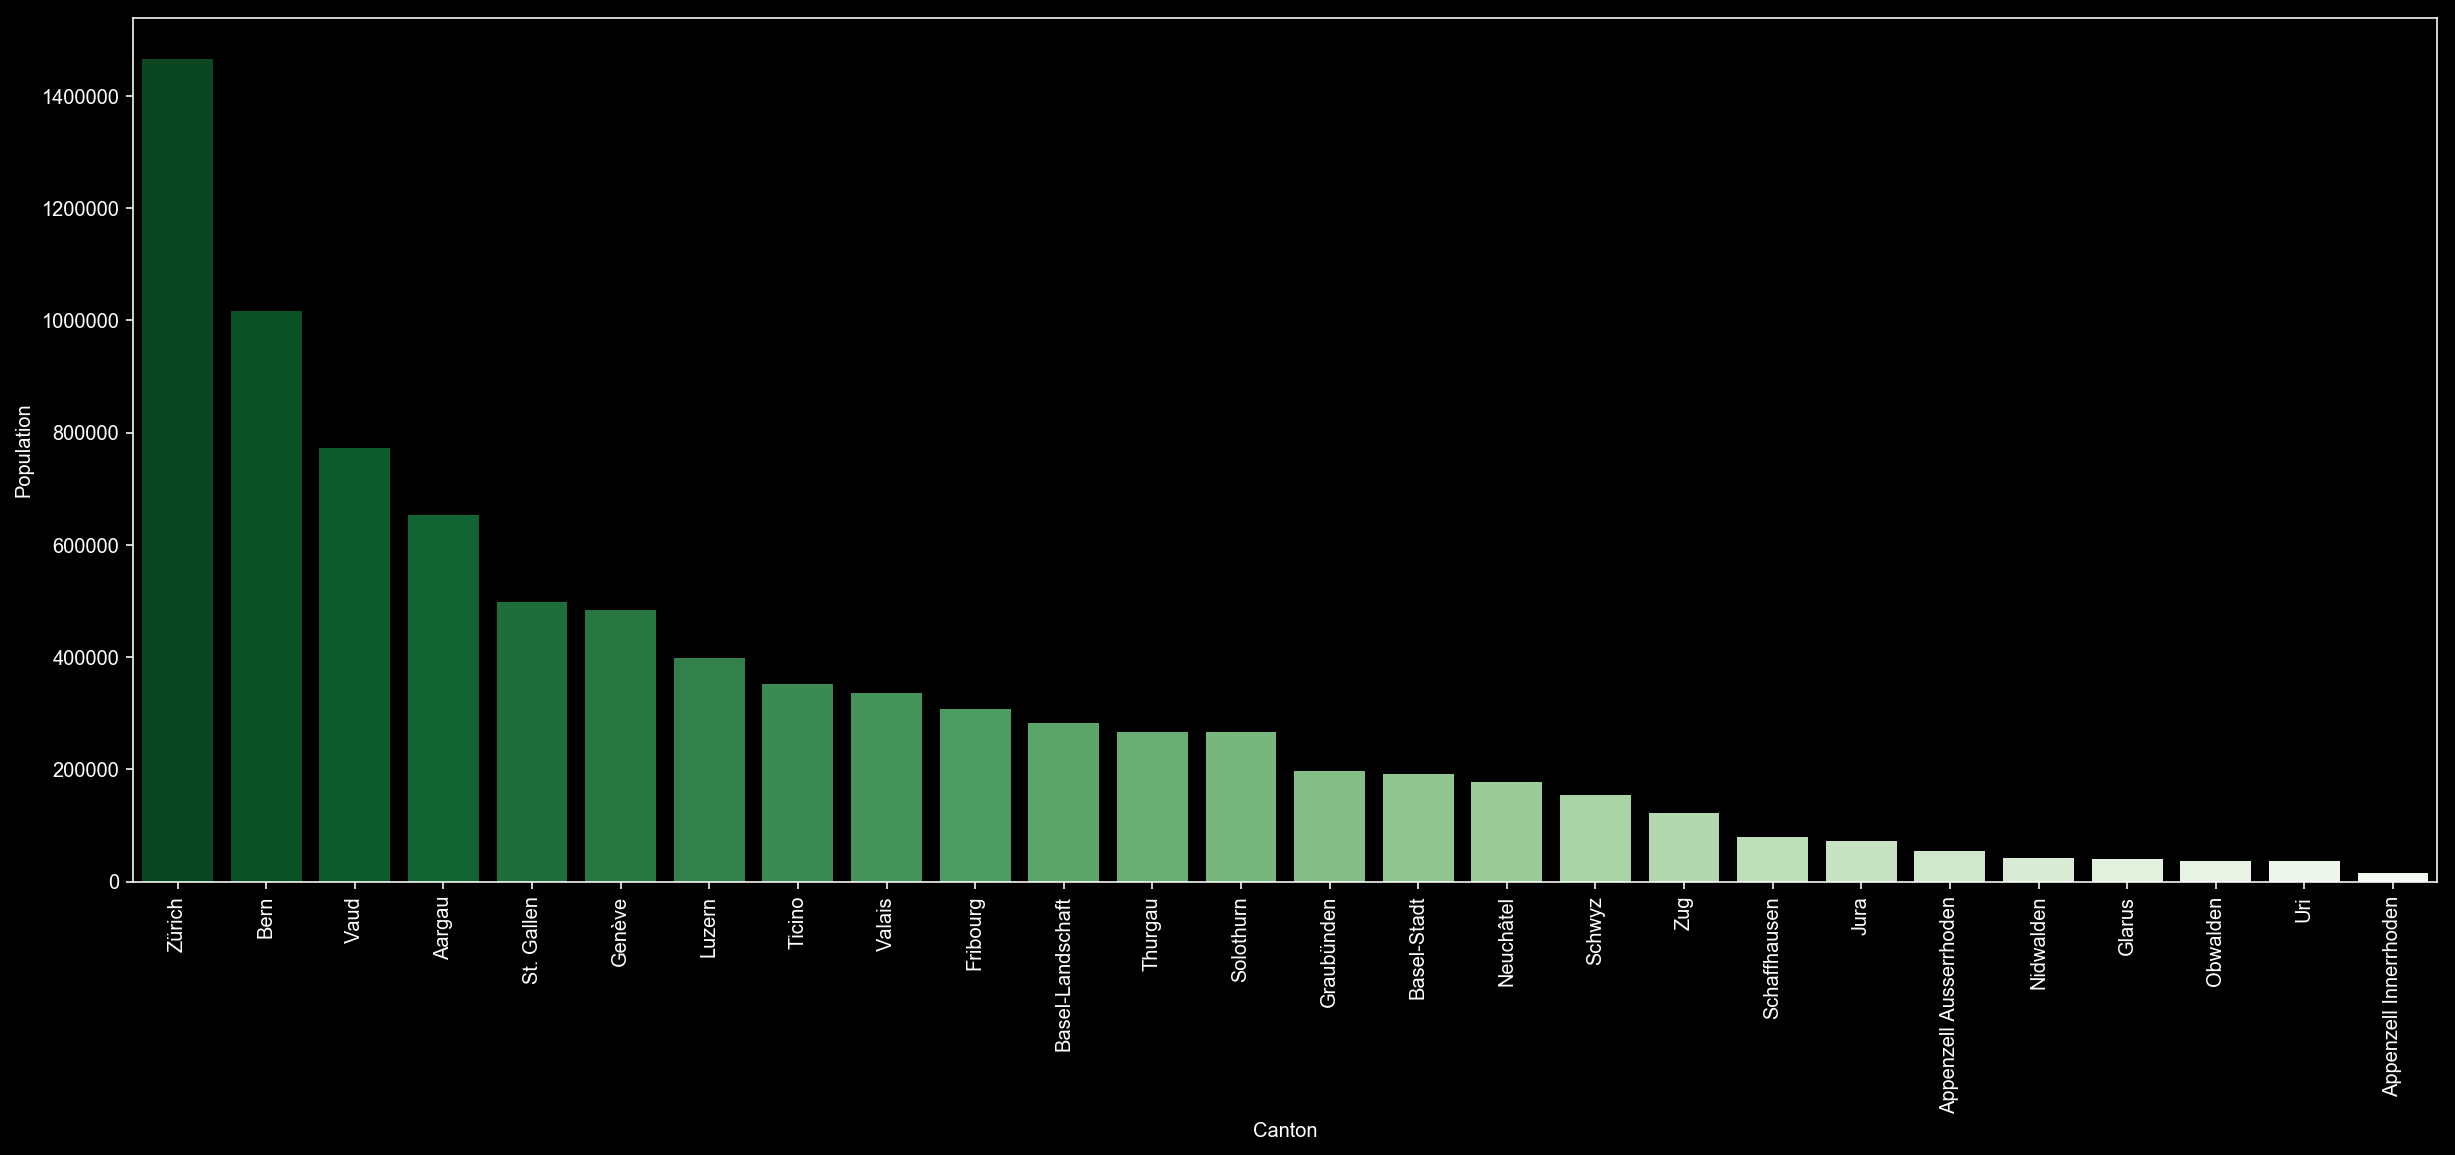

In [13]:
bg_color = 'black'
fg_color = 'white'

fig = plt.figure(facecolor=bg_color, edgecolor=fg_color, figsize=(20,7.5))
axes = plt.axes((0.1, 0.1, 0.8, 0.8), axisbg=bg_color)
axes.xaxis.set_tick_params(color=fg_color, labelcolor=fg_color)
axes.yaxis.set_tick_params(color=fg_color, labelcolor=fg_color)
for spine in axes.spines.values():
    spine.set_color(fg_color)
axes.grid(False)
x = np.linspace(0, 2 * np.pi, 100)
y = np.sin(x)

sns.set(font_scale = 2)
gplot = sns.barplot(x='name', y='pop', data=a, palette=colors)
gplot.set_xticklabels(name, rotation=90);
plt.ylabel('Population', color=fg_color)
plt.xlabel('Canton', color=fg_color)


In [ ]:
fig.savefig(pathPresentation+'\cantonPopulation.png', dpi= 300, bbox_inches='tight', facecolor = 'black')

# 4. Plot District Population

In [14]:
### Retrieve data from Official Statistical office
### Retrieve Information Of Cantons
sparql = SPARQLWrapper("https://sparql.geo.admin.ch/sparql")
query = """
PREFIX schema: <http://schema.org/>
PREFIX gn: <http://www.geonames.org/ontology#>
PREFIX geo: <http://www.opengis.net/ont/geosparql#>
select ?Canton ?Population ?Coords ?cantonName ?bfsNumber ?Geometry
where
{
    ?Canton a gn:A.ADM2 .
    ?Canton schema:name ?cantonName .
    ?Canton gn:population ?Population .
    ?Canton geo:hasGeometry ?Geometry .
    ?Geometry geo:asWKT ?Coords.
    ?Canton <https://ld.geo.admin.ch/def/bfsNumber> ?bfsNumber.
    ?Canton <http://purl.org/dc/terms/issued> ?Date .
    FILTER (?Date = "2017-01-01"^^xsd:date)
}
ORDER BY DESC(?Population)
"""
sparql.setQuery(query)
sparql.setReturnFormat(JSON)
results1 = sparql.query().convert()

In [15]:
c = 0
pop = []
name = []
for result in results1["results"]["bindings"]:
    name.append(result["cantonName"]['value'])
    pop.append(int(result["Population"]['value']))
a = pd.DataFrame()
a['name'] = name
a['pop'] = pop

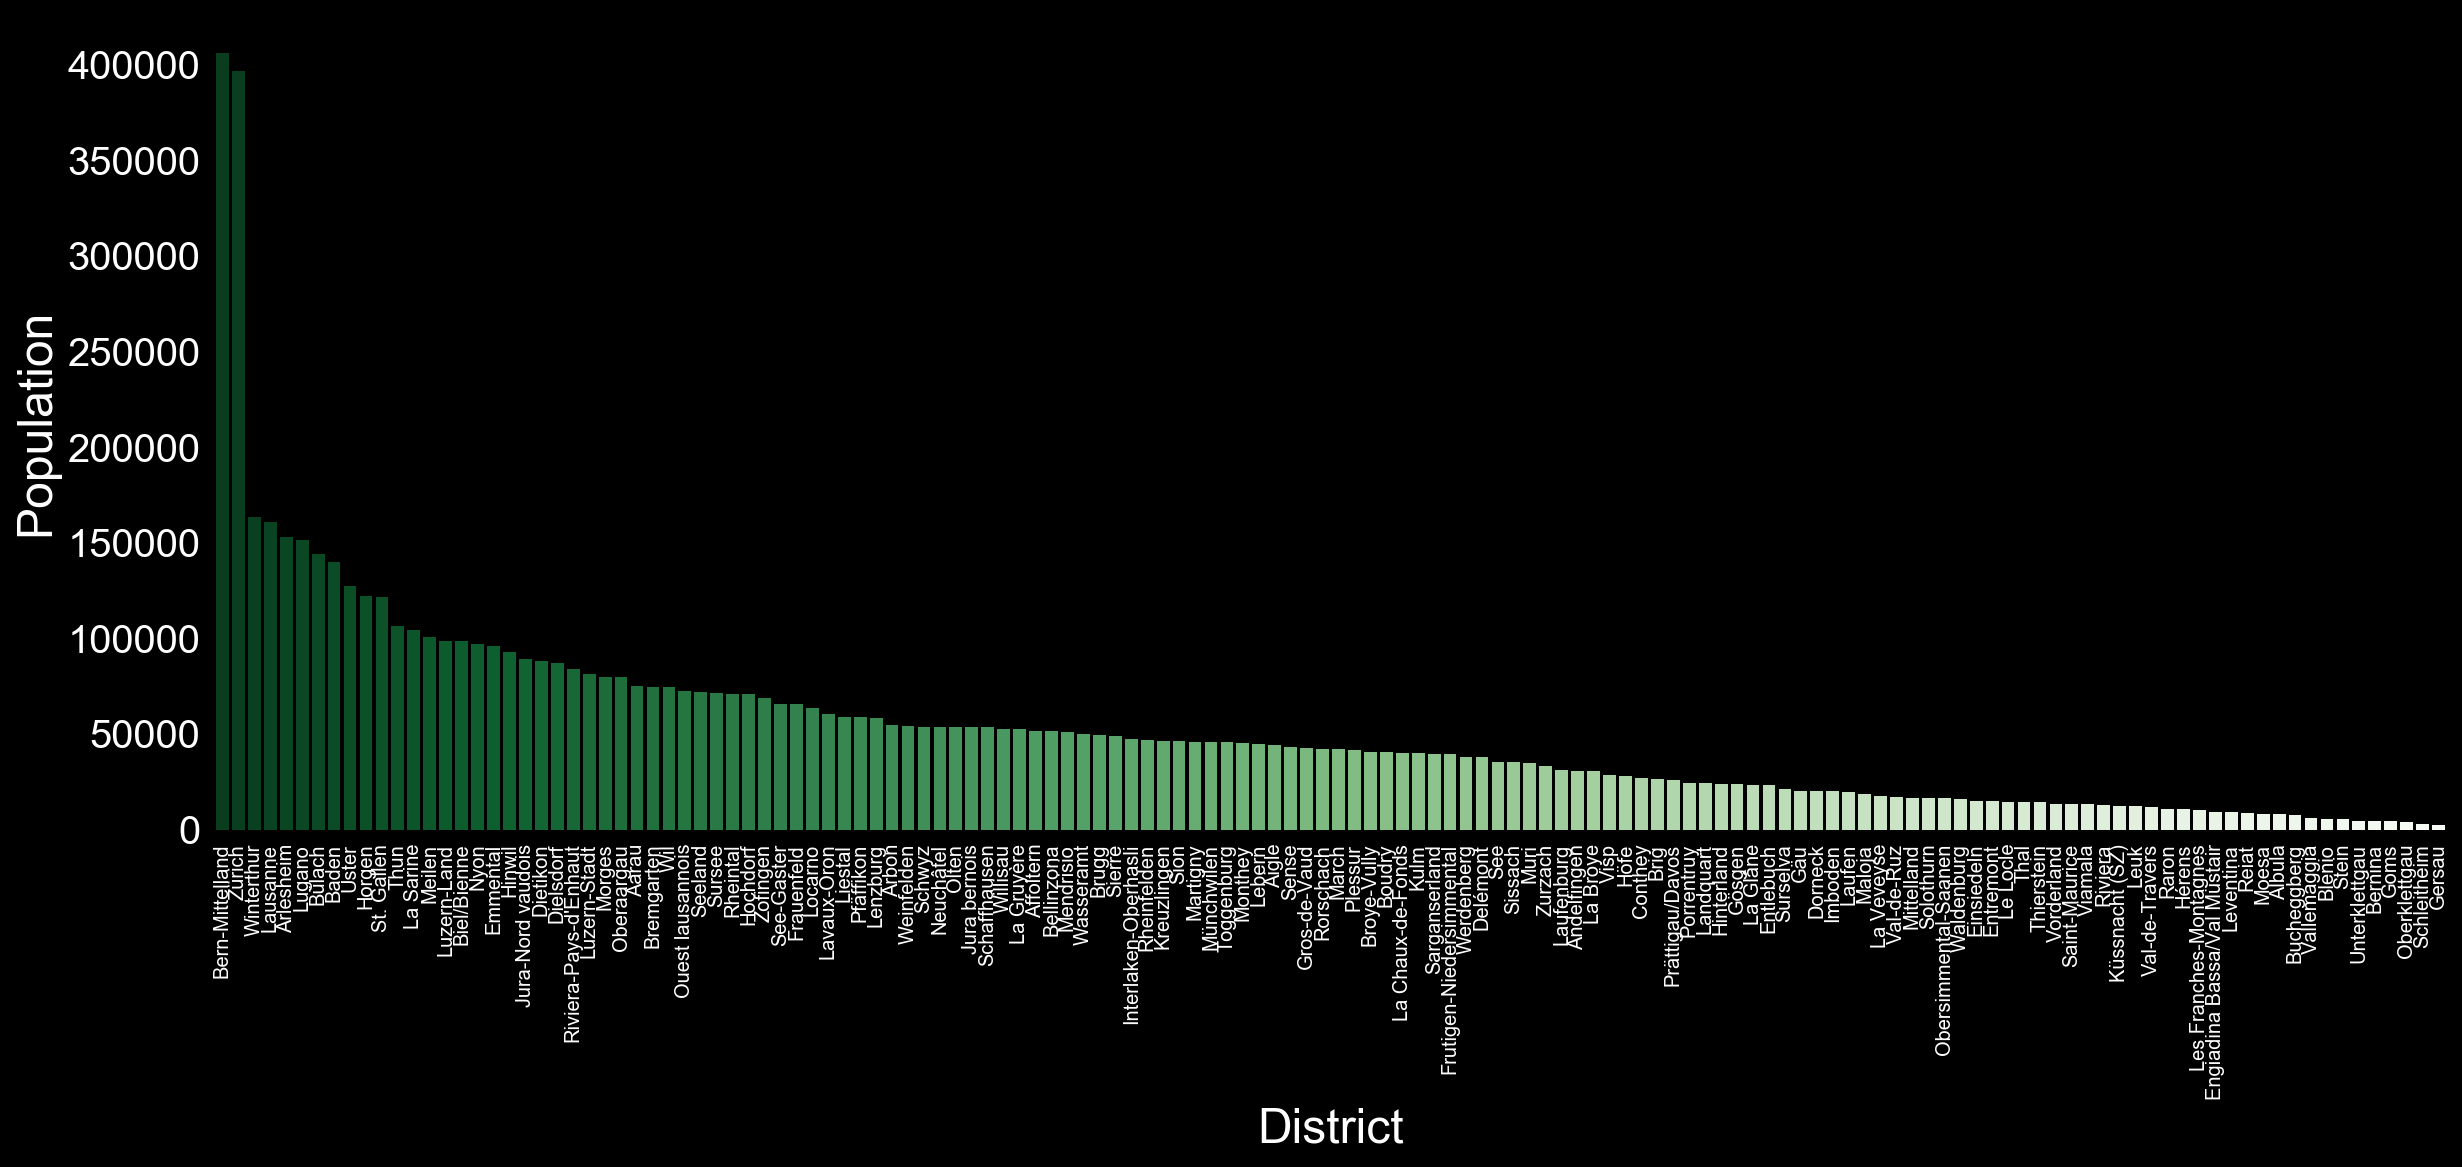

In [16]:
bg_color = 'black'
fg_color = 'white'

fig = plt.figure(facecolor=bg_color, edgecolor=fg_color, figsize=(20,7.5))
axes = plt.axes(axisbg=bg_color)
axes.xaxis.set_tick_params(color=fg_color, labelcolor=fg_color)
axes.yaxis.set_tick_params(color=fg_color, labelcolor=fg_color)
for spine in axes.spines.values():
    spine.set_color(fg_color)
axes.grid(False)

sns.set(font_scale = 1)
gplot = sns.barplot(x='name', y='pop', data=a, palette=colors)
gplot.set_xticklabels(name, rotation=90);
plt.ylabel('Population', color=fg_color, size = 24)
plt.xlabel('District', color=fg_color, size = 24)

plt.tick_params(axis='x', which='major', labelsize=10)
plt.tick_params(axis='y', which='major', labelsize=20)

In [ ]:
fig.savefig(pathPresentation+'\districtPopulation.png', dpi= 300, bbox_inches='tight', facecolor = 'black')

# Retrieve Municpality Data

In [76]:
sparql = SPARQLWrapper("https://sparql.geo.admin.ch/sparql")
query = """
PREFIX schema: <http://schema.org/>
PREFIX gn: <http://www.geonames.org/ontology#>
PREFIX geo: <http://www.opengis.net/ont/geosparql#>

select ?Municipality ?Name ?bfsNumber ?Geometry ?Coords
where
{
?Municipality a gn:A.ADM3.
?Municipality schema:name ?Name .
?Municipality <https://ld.geo.admin.ch/def/bfsNumber> ?bfsNumber .
?Municipality geo:hasGeometry ?Geometry.
?Geometry geo:asWKT ?Coords.

}
ORDER BY DESC(?Name)
"""

In [77]:
sparql.setQuery(query)
sparql.setReturnFormat(JSON)
results1 = sparql.query().convert()

In [78]:
c = 0
code = []
coord = []
for result in results1["results"]["bindings"]:
    code.append(result["bfsNumber"]['value'])
    coord.append(result["Coords"]['value'])

In [101]:
municipalityData = pd.DataFrame({'Code':code, 'geom':coord})
municipalityData = municipalityData.drop_duplicates(subset=['Code'], keep = 'last')

In [102]:
keyData = pd.read_csv("Data\keyData2017.csv")
municipalityData['Code'] = municipalityData.Code.astype(int)

In [103]:
mergeVal = pd.merge(municipalityData,keyData, on='Code', how="outer")

In [104]:
mergeVal = pd.merge(municipalityData,keyData, on='Code', how="outer")

# 5. Plot Municipality Data

In [21]:
### Retrieve data from Official Statistical office
### Retrieve Information Of Cantons
sparql = SPARQLWrapper("https://sparql.geo.admin.ch/sparql")
query = """
PREFIX schema: <http://schema.org/>
PREFIX gn: <http://www.geonames.org/ontology#>
PREFIX geo: <http://www.opengis.net/ont/geosparql#>
PREFIX dbo: <http://dbpedia.org/ontology/>
select ?Municipality ?Population ?Coords ?municipalityName ?bfsNumber ?Geometry 
where
{
    ?Municipality a gn:A.ADM3 .
    ?Municipality schema:name ?municipalityName .
    ?Municipality gn:population ?Population .
    ?Municipality geo:hasGeometry ?Geometry .
    ?Geometry geo:asWKT ?Coords.
    ?Municipality <https://ld.geo.admin.ch/def/bfsNumber> ?bfsNumber.
    ?Municipality <http://purl.org/dc/terms/issued> ?Date .
    FILTER (?Date = "2017-01-01"^^xsd:date)
}
ORDER BY DESC(?Population)
"""
sparql.setQuery(query)
sparql.setReturnFormat(JSON)
results1 = sparql.query().convert()

## 5.1 Plot Geo Inhabitants

In [22]:
c = 0
pop = []
name = []
coord = []
code = []
for result in results1["results"]["bindings"]:
    name.append(result["municipalityName"]['value'])
    pop.append(int(result["Population"]['value']))
    coord.append(result["Coords"]['value'])
    code.append(result["bfsNumber"]['value'])
pop = log(pop)
a = pd.DataFrame()
a['name'] = name
a['pop'] = pop
a['Code'] = code

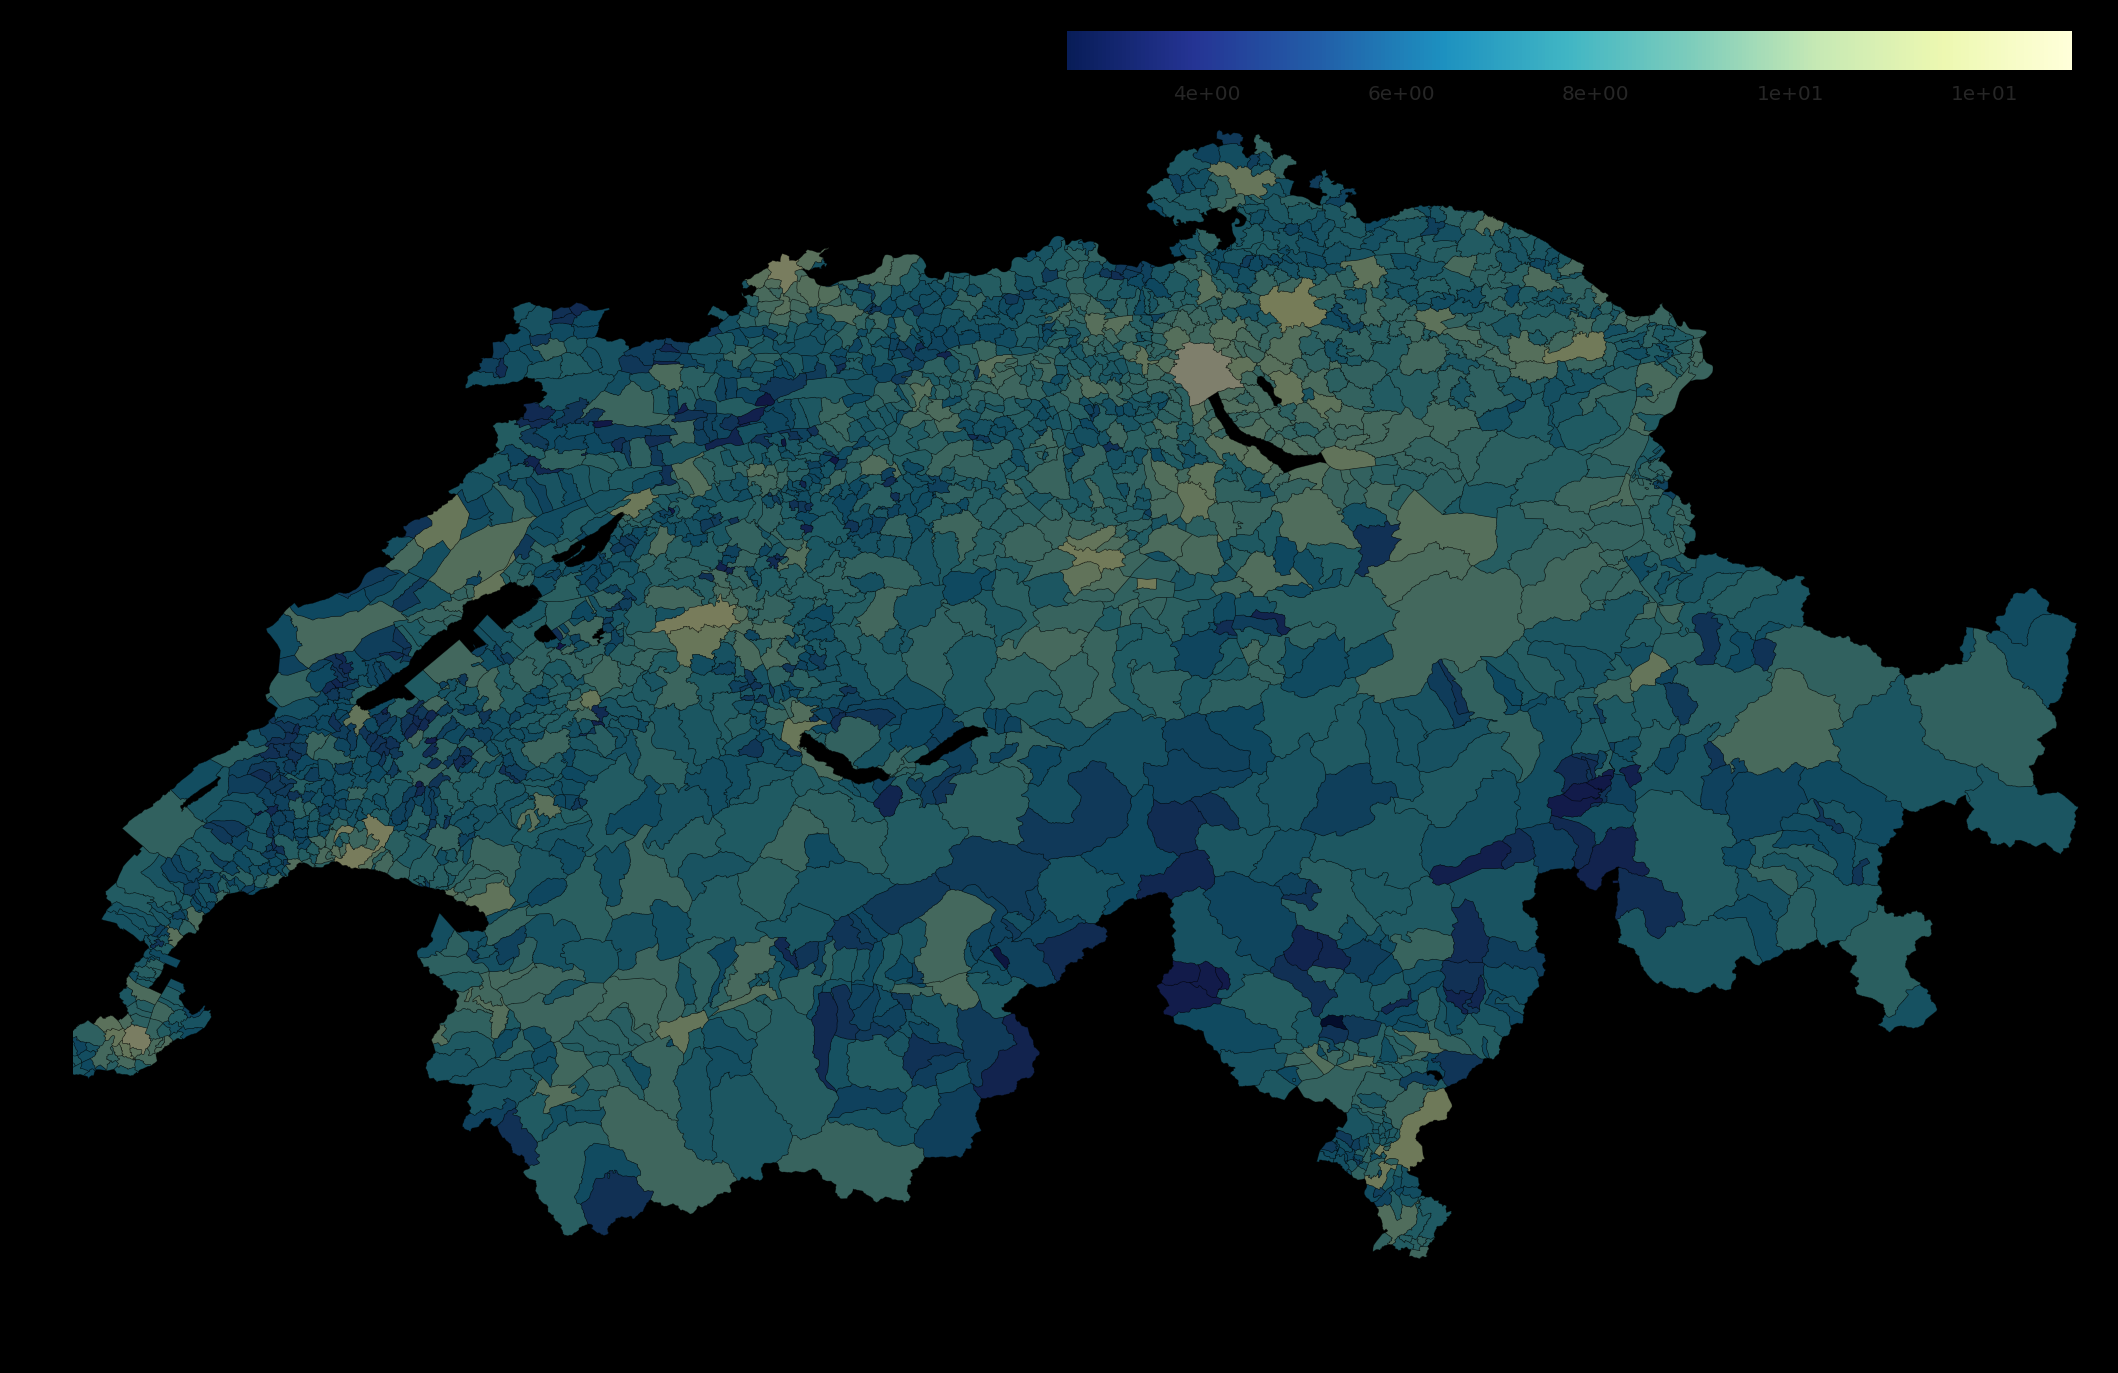

In [23]:
cmap = plt.get_cmap('YlGnBu')
cmap_r = reverse_colourmap(cmap)
norm = matplotlib.colors.Normalize(min(pop), max(pop))
color_producer = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap_r)
count = 0
font = {'family' : 'normal',
        'size'   : 50}

matplotlib.rc('font', **font)

bg_color = 'black'
fg_color = 'white'

fig = plt.figure(facecolor=bg_color, edgecolor=fg_color, figsize=(18,12))
axes = plt.axes(axisbg=bg_color)
axes.xaxis.set_tick_params(color=fg_color, labelcolor=fg_color)
axes.yaxis.set_tick_params(color=fg_color, labelcolor=fg_color)
for spine in axes.spines.values():
    spine.set_color(fg_color)
axes.grid(False)
for result in results1["results"]["bindings"]:
    tmp = result["Coords"]['value']
    p = wkt.loads(tmp)
    cc = color_producer.to_rgba( pop[count] )
    count += 1
    ptchs   = []
    for polygon in p:
    #plot_coords(ax, polygon.exterior)
        patch = PolygonPatch(polygon, facecolor=cc,
                         edgecolor= 'k', alpha=0.5, zorder=2)
        ptchs.append(patch)
        h = PatchCollection(ptchs,facecolor=cc, linewidths = 1)
        axes.add_patch(patch)
axes.set_xlim(6, 10.5)
axes.set_ylim(45.7,48)

plt.axis('off')


h.set(array = pop, cmap=cmap_r)
cbaxes = inset_axes(axes, width="50%", height="3%", loc=1) 
cb = plt.colorbar(h, cax=cbaxes, orientation='horizontal', format='%.0e')
cb.ax.yaxis.set_tick_params(color='white')

## 5.2 Link external Dataset

In [97]:
kd = mergeVal.dropna().reset_index(drop=True)
len(kd)

2289

### Plot Indicators

In [98]:
cmap = plt.get_cmap('hot')
value = mergeVal['Population density per km\xc2\xb2']
value = log(value)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

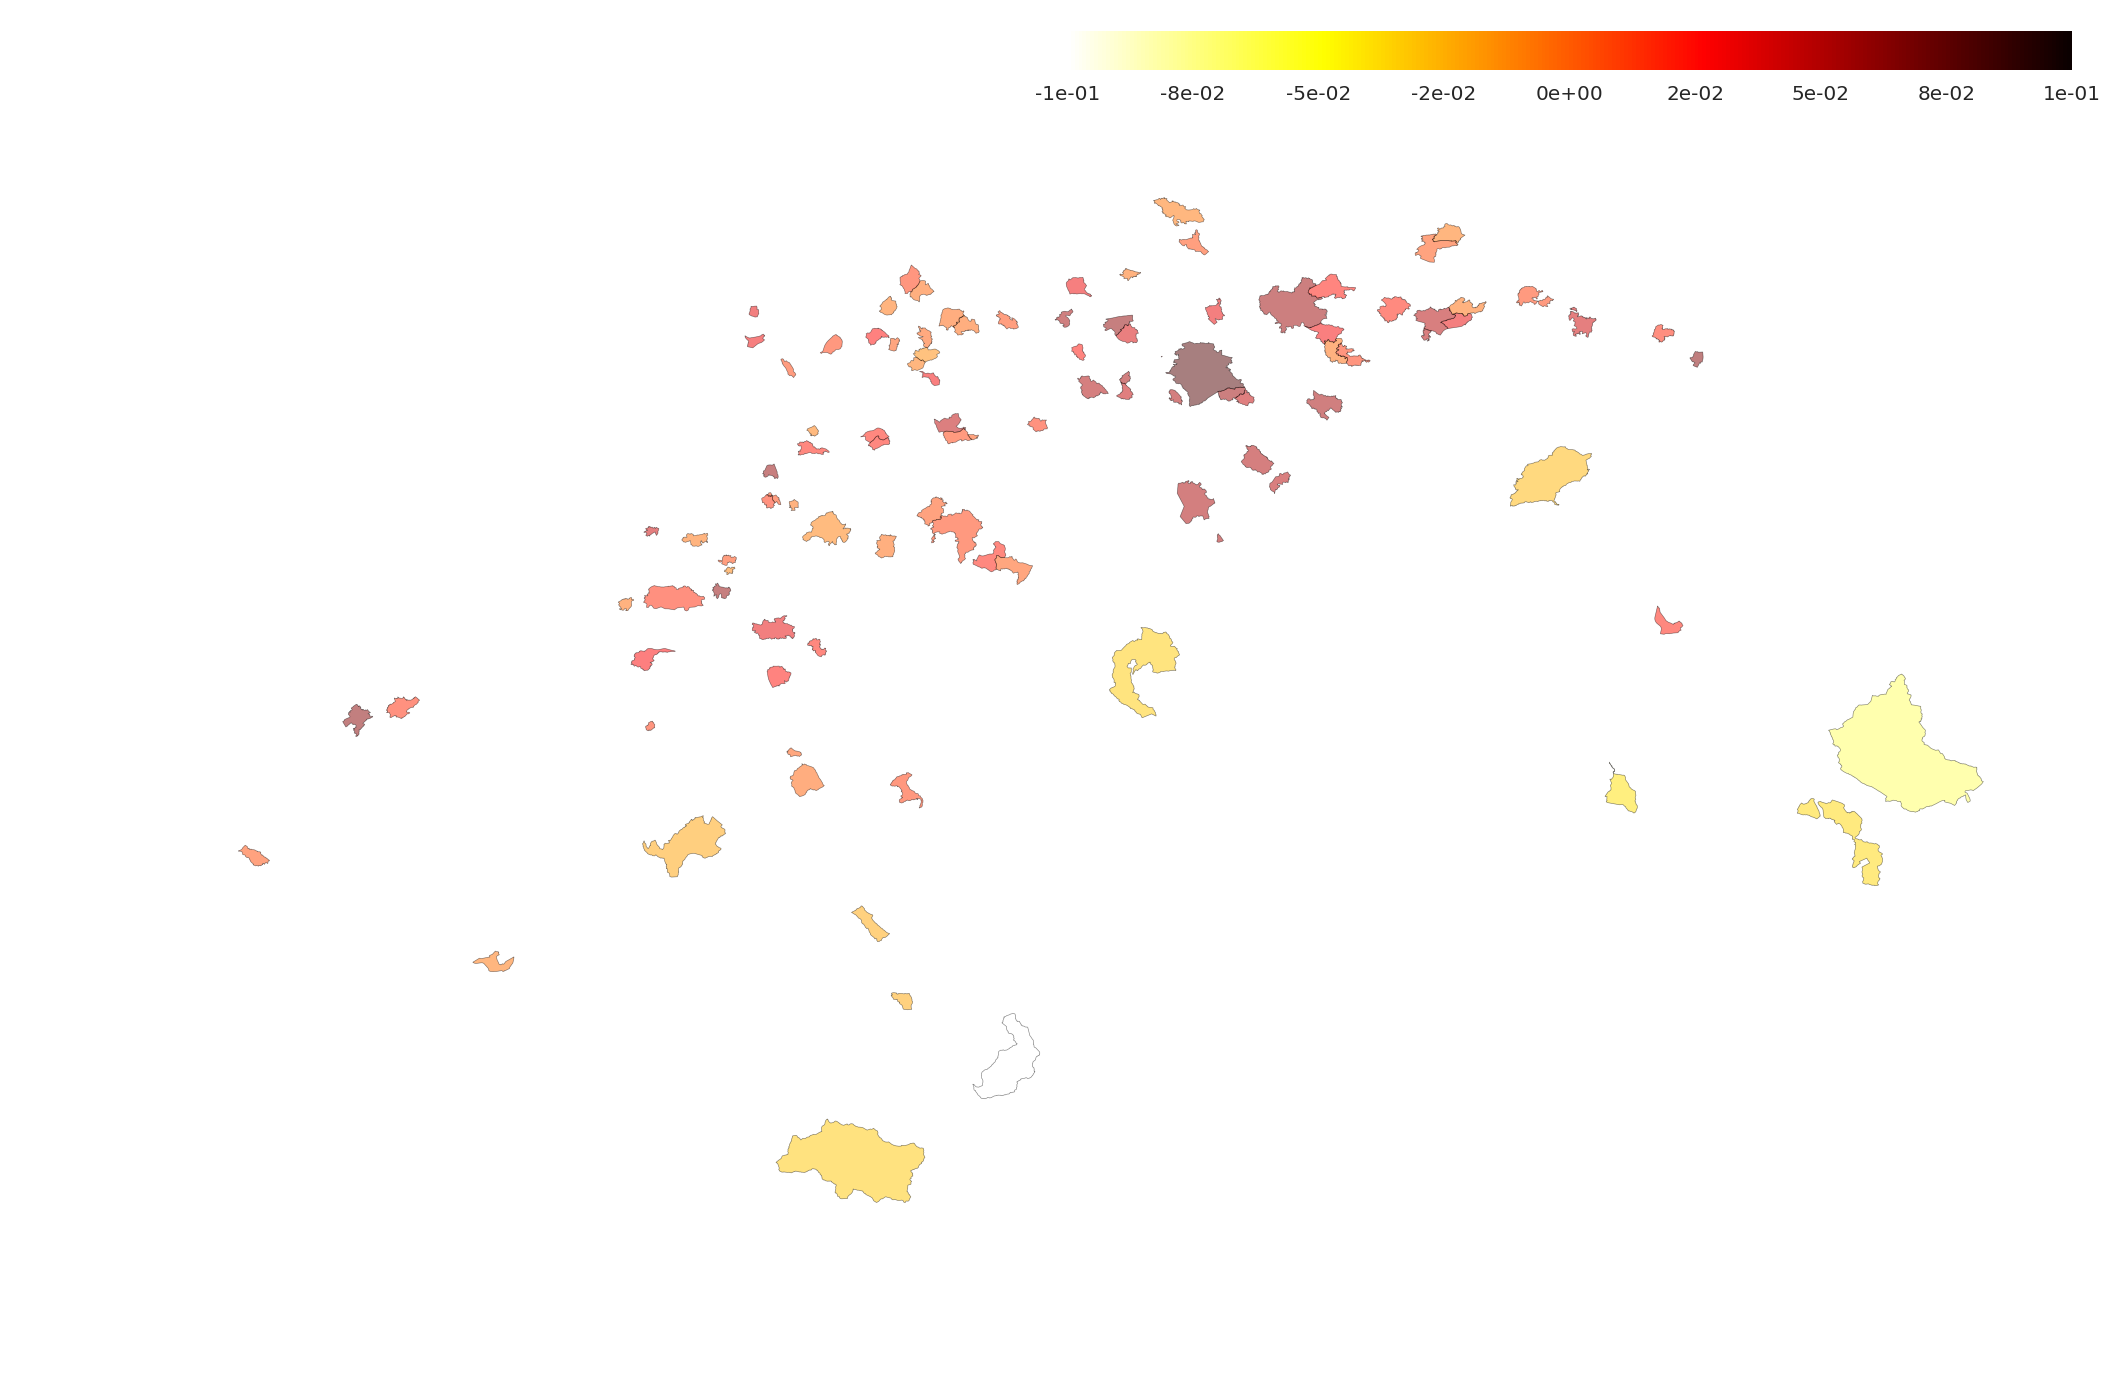

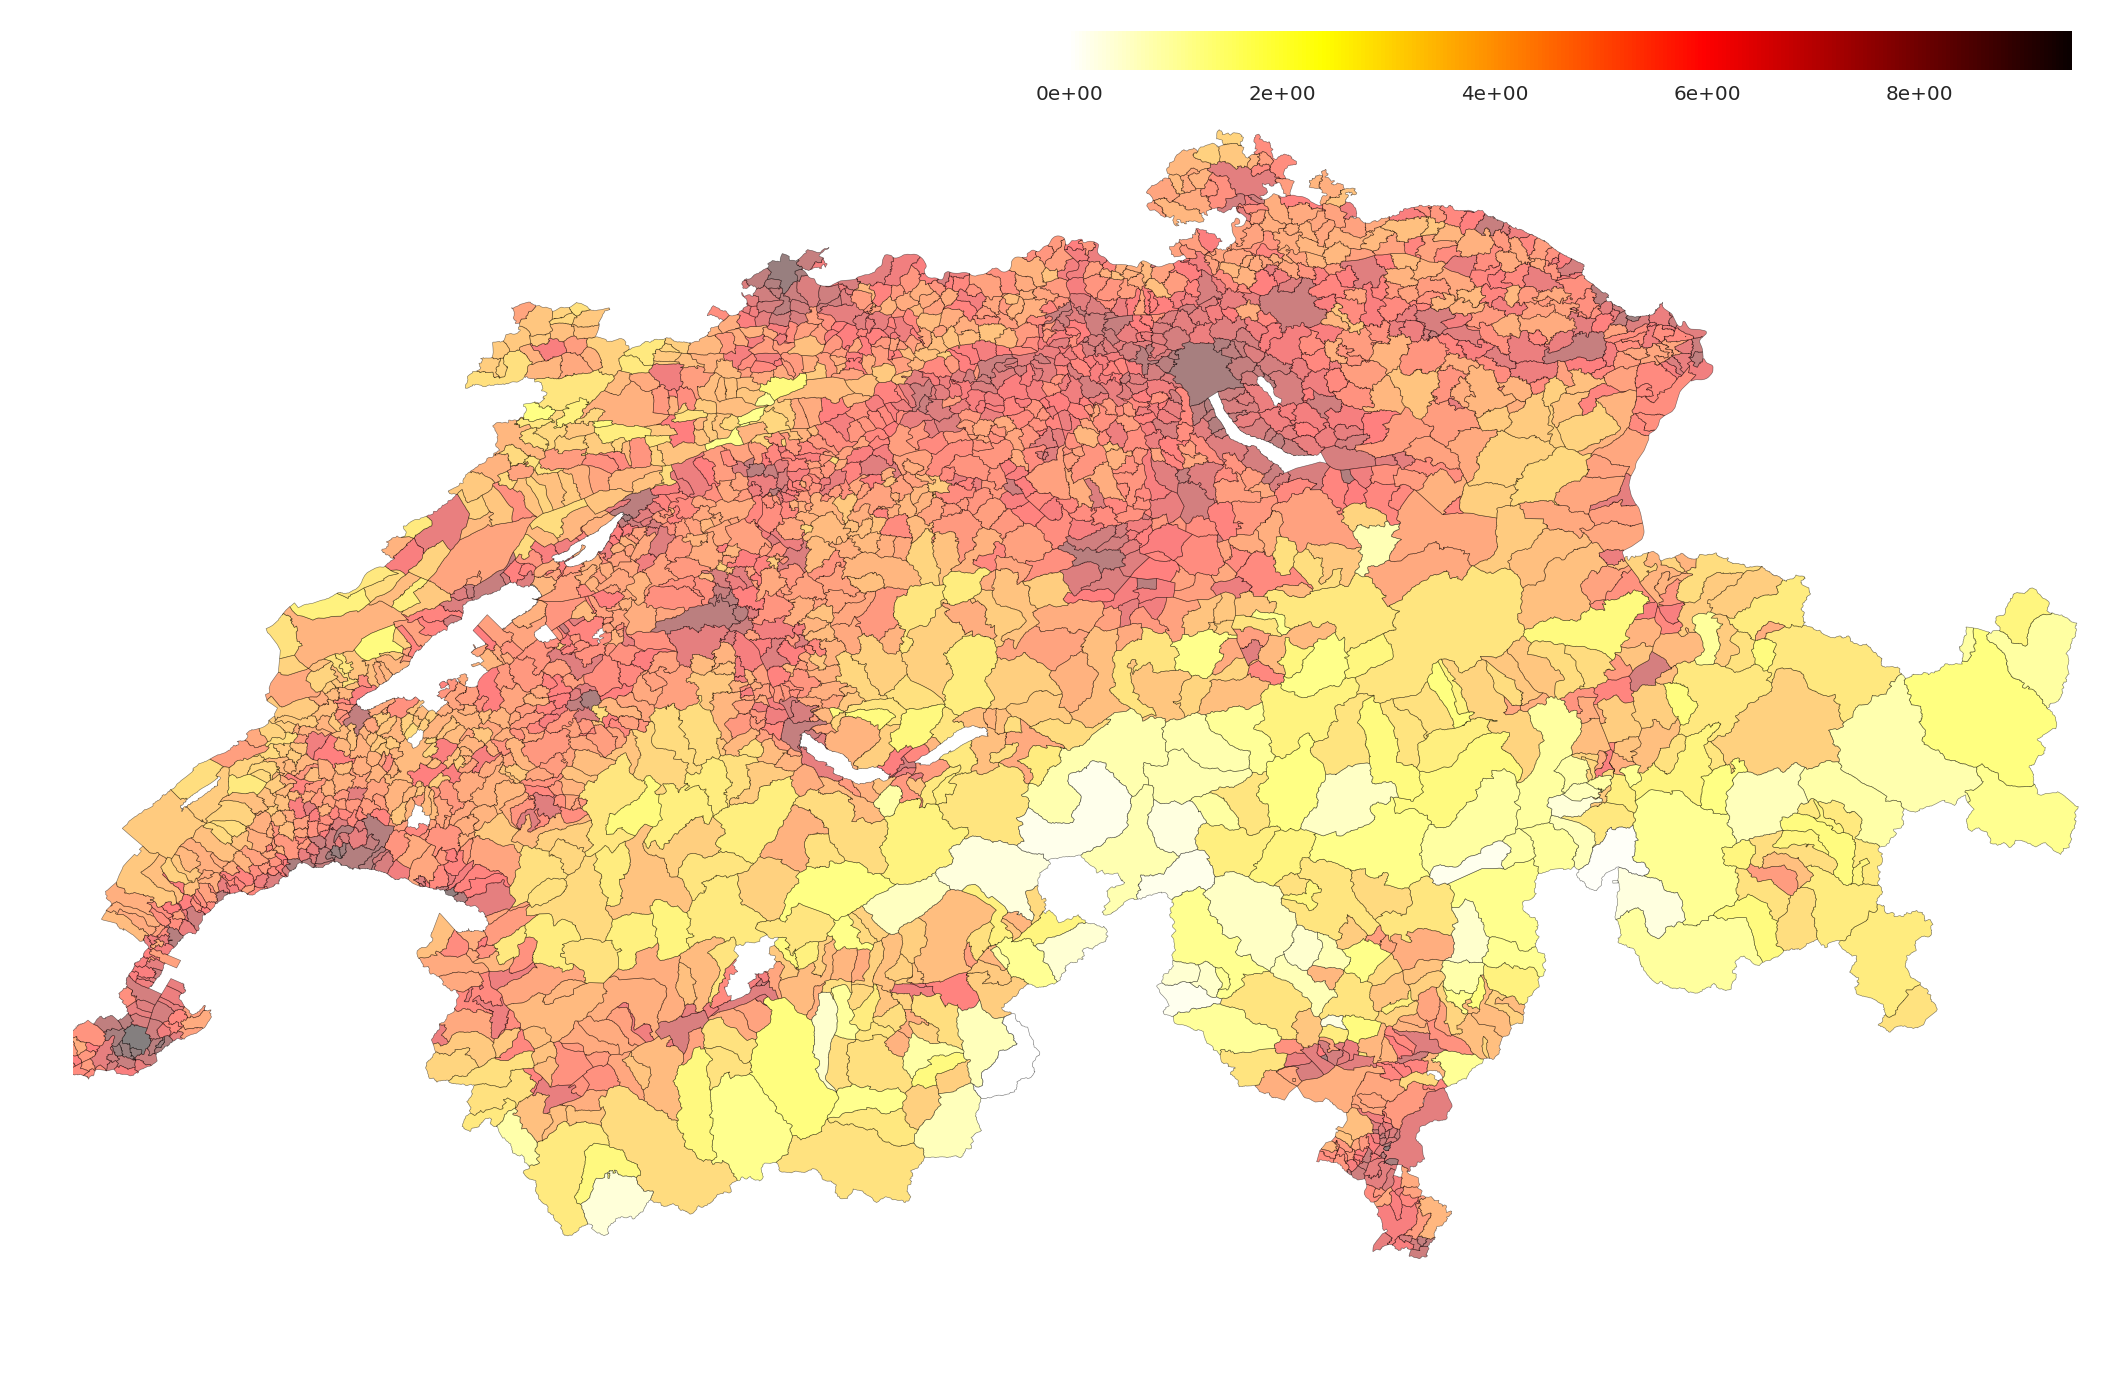

In [191]:
plotIndicators(cmap, value, results1)   

In [192]:
cmap = plt.get_cmap('hot')
value = mergeVal['Employed total']
value = log(value)

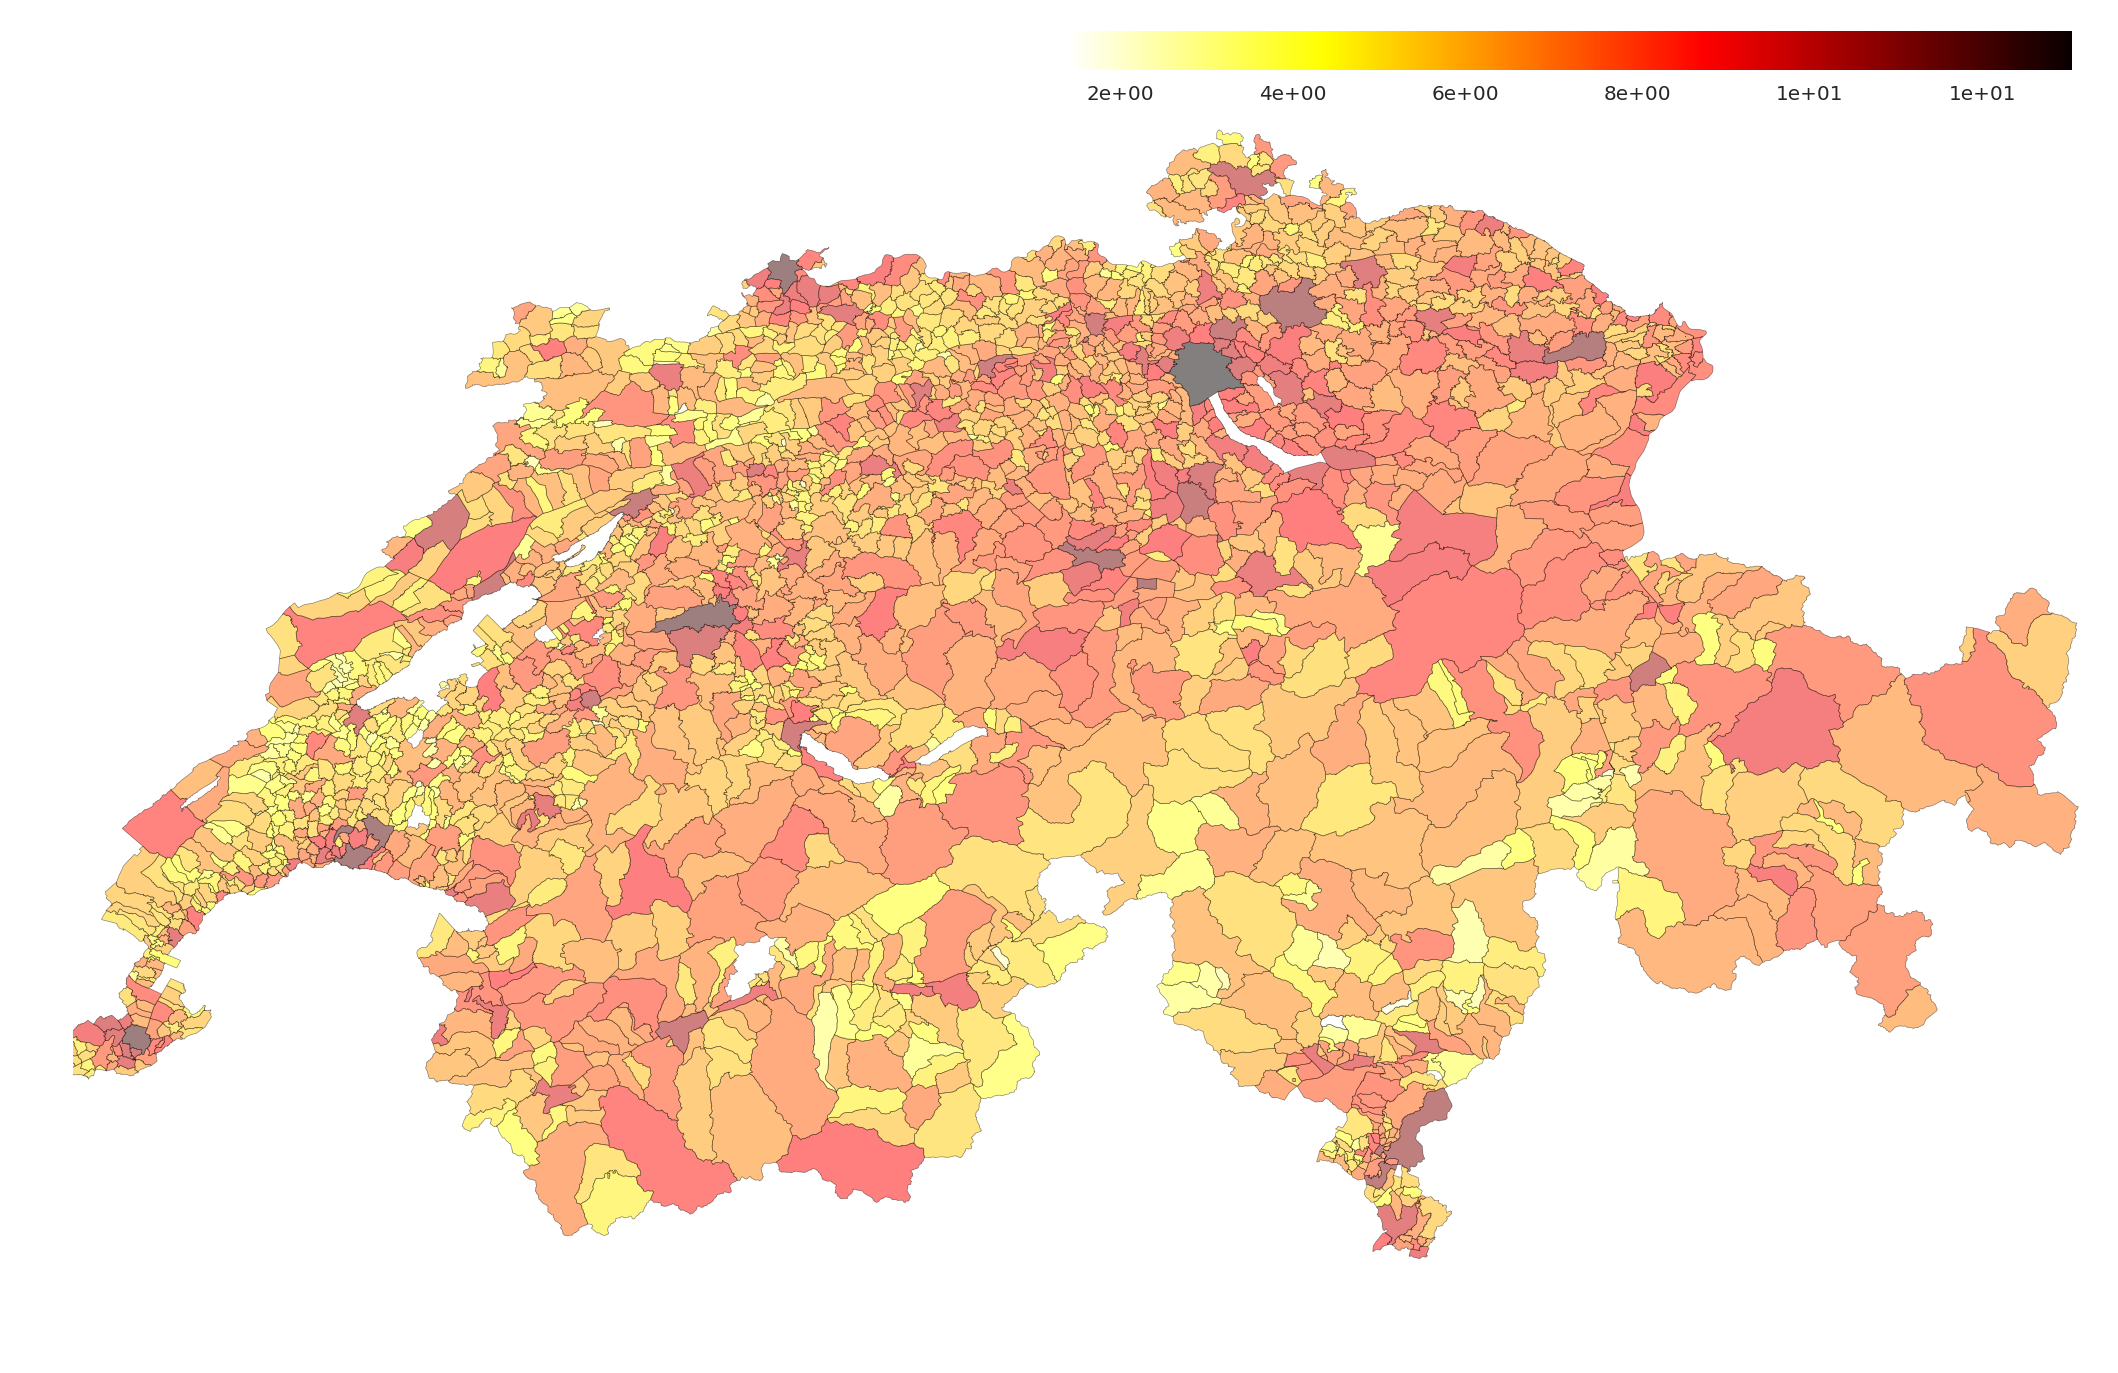

In [193]:
plotIndicators(cmap, value, results1)   

In [ ]:
nameC = "Country1"
idS = URIRef(FOCUS[nameC])
nameC = Literal("Switzerland")
g.add((idS, RDF.type, dbo.country))
g.add((idS, FOAF.name, nameC))

In [ ]:
sparql = SPARQLWrapper("http://dbpedia.org/sparql")
query = """
    PREFIX dbo:  <http://dbpedia.org/ontology/>
    PREFIX dbpedia: <http://dbpedia.org/resource/>
    PREFIX dbp: <http://dbpedia.org/property/>
    PREFIX geo: <http://www.w3.org/2003/01/geo/wgs84_pos#>
    SELECT DISTINCT  ?s ?pop ?code 
    WHERE{ 
       ?s rdf:type dbo:PopulatedPlace.
       ?s geo:lat ?lat.
       ?s geo:lat ?lon.
       ?s rdfs:label ?name.
       ?s dbo:populationTotal ?pop.
       ?s geo:geometry ?geom.
       ?s dbp:iso3166code ?code.
       FILTER (?s = dbpedia:Switzerland)
    }
"""
sparql.setQuery(query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()

## 2.1 Add Information to the graph

In [ ]:
for result in results["results"]["bindings"]:
    tmp = Literal(result["code"]['value'])
    g.add((idS, dbp.iso3166code, tmp))
    tmp = Literal(result["pop"]['value'])
    g.add((idS, dbo.populationTotal, tmp))

# 3. Canton Data

In [ ]:
### Retrieve data from Official Statistical office
### Retrieve Information Of Cantons
sparql = SPARQLWrapper("https://sparql.geo.admin.ch/sparql")
query = """
PREFIX schema: <http://schema.org/>
PREFIX gn: <http://www.geonames.org/ontology#>
PREFIX geo: <http://www.opengis.net/ont/geosparql#>
select ?Canton ?Population ?Coords ?cantonName ?bfsNumber ?Geometry
where
{
    ?Canton a gn:A.ADM1 .
    ?Canton schema:name ?cantonName .
    ?Canton gn:population ?Population .
    ?Canton geo:hasGeometry ?Geometry .
    ?Geometry geo:asWKT ?Coords.
    ?Canton <https://ld.geo.admin.ch/def/bfsNumber> ?bfsNumber.
    ?Canton <http://purl.org/dc/terms/issued> ?Date .
    FILTER (?Date = "2017-01-01"^^xsd:date)
}
ORDER BY DESC(?Population)
"""
sparql.setQuery(query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()

## 3.1 Add information to the graph

In [ ]:
c = 0
pop = []
name = []
for result in results["results"]["bindings"]:
    c = c + 1
    nameC = "canton%d"%c
    idS = URIRef(FOCUS[nameC])
    g.add((idS, RDF.type, dbo.canton))
    
    tmp = Literal(result["cantonName"]['value'])
    g.add((idS, FOAF.name, tmp))
    
    tmp = Literal(result["Population"]['value'])
    g.add((idS, dbo.populationTotal, tmp))
    
    g.add((idS, dbo.Country, FOCUS.country1))
    
    name.append(result["cantonName"]['value'])
    pop.append(int(result["Population"]['value']))

## 3.2 Plot Cantons Population

In [ ]:
a = pd.DataFrame()
a['pop'] = pop
a['name'] = name
colors = sns.color_palette("BuGn_r", len(a))
fig,ax = plt.subplots(figsize=(15,7.5))
sns.set(font_scale = 1.5)
gplot = sns.barplot(x='name', y='pop', data=a, palette=colors)
gplot.set_xticklabels(name, rotation=90);
ax.set_ylabel('Poulation');
ax.set_xlabel('');

In [ ]:
g.serialize(destination='outputProva.nt', format='nt')

# 4. District Data

In [ ]:
### Retrieve data from Official Statistical office
### Retrieve Information Of Cantons
sparql = SPARQLWrapper("https://sparql.geo.admin.ch/sparql")
query = """
PREFIX schema: <http://schema.org/>
PREFIX gn: <http://www.geonames.org/ontology#>
PREFIX geo: <http://www.opengis.net/ont/geosparql#>
select ?Population ?Coords ?districtName ?bfsNumber ?Geometry ?Canton
where
{
    ?District a gn:A.ADM2 .
    ?District schema:name ?districtName .
    ?District gn:population ?Population .
    ?District geo:hasGeometry ?Geometry .
    ?District gn:parentADM1 ?Canton.
    ?Geometry geo:asWKT ?Coords.
    ?District <https://ld.geo.admin.ch/def/bfsNumber> ?bfsNumber.
    ?District <http://purl.org/dc/terms/issued> ?Date .
    FILTER (?Date = "2016-01-01"^^xsd:date)
}
ORDER BY DESC(?Population)
"""
sparql.setQuery(query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()

## 4.1 Add information to the graph

In [ ]:
c = 0
pop = []
name = []
for result in results["results"]["bindings"]:
    c = c + 1
    nameC = "district%d"%c
    idS = URIRef(FOCUS[nameC])
    g.add((idS, RDF.type, dbo.district))
    
    tmp = Literal(result["districtName"]['value'])
    g.add((idS, FOAF.name, tmp))
    
    tmp = Literal(result["Population"]['value'])
    g.add((idS, dbo.populationTotal, tmp))
    
    g.add((idS, dbo.Country, FOCUS.country1))
    
    
    g.add((idS, dbo.canton, FOCUS.country1))
    
    name.append(result["districtName"]['value'])
    pop.append(int(result["Population"]['value'])

In [ ]:
g.serialize(destination='outputProva.nt', format='nt')

## 4.2 Plot District Population

In [ ]:
a = pd.DataFrame()
a['pop'] = pop
a['name'] = name
colors = sns.color_palette("BuGn_r", len(a))
fig,ax = plt.subplots(figsize=(20,7.5))
sns.set(font_scale = 1)
gplot = sns.barplot(x='name', y='pop', data=a, palette=colors)
gplot.set_xticklabels(name, rotation=90);
ax.set_ylabel('Poulation');
ax.set_xlabel('');

In [ ]:
cmap = plt.get_cmap('gnuplot')
norm = matplotlib.colors.Normalize(min(pop), max(pop))
color_producer = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
count = 0
fig,ax = plt.subplots(figsize=(18,11))
for result in results["results"]["bindings"]:
    tmp = result["Coords"]['value']
    p = wkt.loads(tmp)
    cc = color_producer.to_rgba( pop[count] )
    count += 1
    for polygon in p:
    #plot_coords(ax, polygon.exterior)
        patch = PolygonPatch(polygon, facecolor=cc,
                         edgecolor= 'k', alpha=0.5, zorder=2)
        ax.add_patch(patch)
ax.set_xlim(5.5, 11)
ax.set_ylim(45.5,48)


In [ ]:
g.serialize(destination='outputProva.nt', format='nt')

In [ ]:
cmap = plt.get_cmap('gnuplot')
norm = matplotlib.colors.Normalize(min(pop), max(pop))
color_producer = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
count = 0
fig,ax = plt.subplots(figsize=(18,11))
for result in results["results"]["bindings"]:
    tmp = result["Coords"]['value']
    p = wkt.loads(tmp)
    cc = color_producer.to_rgba( pop[count] )
    count += 1
    for polygon in p:
    #plot_coords(ax, polygon.exterior)
        patch = PolygonPatch(polygon, facecolor=cc,
                         edgecolor= 'k', alpha=0.5, zorder=2)
        ax.add_patch(patch)
ax.set_xlim(5.5, 11)
ax.set_ylim(45.5,48)

In [ ]:
for nshp in range(0, len(p)):
    print "ciao"


In [ ]:
g.serialize(destination='outputProva.nt', format='nt')

In [ ]:
### Retrieve data from Official Statistical office
### Retrieve Information Of District
sparql = SPARQLWrapper("https://sparql.geo.admin.ch/sparql")
query = """
PREFIX schema: <http://schema.org/>
PREFIX gn: <http://www.geonames.org/ontology#>
PREFIX geo: <http://www.opengis.net/ont/geosparql#>
select ?Canton ?Population ?Coords ?cantonName ?bfsNumber
where
{
    ?Canton a gn:A.ADM2 .
    ?Canton schema:name ?cantonName .
    ?Canton gn:population ?Population .
    ?Canton geo:hasGeometry ?Geometry .
    ?Geometry geo:asWKT ?Coords.
    ?Canton <https://ld.geo.admin.ch/def/bfsNumber> ?bfsNumber.
    ?Canton <http://purl.org/dc/terms/issued> ?Date .
    FILTER (?Date = "2017-01-01"^^xsd:date)
}
ORDER BY DESC(?Population)
"""
sparql.setQuery(query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()